In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Conv2D, Flatten, LSTM, GRU

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'gru_regression_model.h5'

C:\Users\psxjmma\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Data Ingestion

In [2]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)


In [3]:
train_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [4]:
#remove the columns 26 and 27 because of NAN values
train_df=train_df.loc[:,0:25]

In [5]:
train_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

In [7]:
train_df.head(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [8]:
# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)

In [9]:
test_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [10]:
#remove the columns 26 and 27 because of NAN values
test_df=test_df.loc[:,0:25]

In [11]:
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [12]:
test_df = test_df.sort_values(['id','cycle'])

In [13]:
test_df.head(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [14]:
#read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)


In [15]:
truth_df.head(10)

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN
5,93,NaN
6,91,NaN
7,95,NaN
8,111,NaN
9,96,NaN


In [16]:
#remove the columns 1 because of NAN values
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [17]:
truth_df.columns = ['cycle']

In [18]:
truth_df.head(5)

,cycle
0,112
1,98
2,69
3,82
4,91


Data Preprocessing

In [19]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
##TRAINING DATASET
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()



In [20]:
rul.columns = ['id', 'max']

In [21]:
train_df = train_df.merge(rul, on=['id'], how='left')


In [22]:
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [23]:
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )


In [24]:
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [25]:
#check for NAN values
np.sum(train_df.isnull())

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
RUL         0
label1      0
label2      0
dtype: int64

In [26]:
#check columns with repeated values: setting3, s1, s5, s10, s16,s18,s19
train_df.apply(lambda x: x.nunique())
train_df.drop(train_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)

In [27]:
#TEST DATASET
test_df.drop(test_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)
test_df.apply(lambda x: x.nunique())

id           100
cycle        303
setting1     150
setting2      14
s2           262
s3          2361
s4          2954
s6             2
s7           415
s8            41
s9          4047
s11          136
s12          357
s13           43
s14         3786
s15         1506
s17            9
s20          103
s21         3555
dtype: int64

In [28]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()


In [29]:
rul.columns = ['id', 'max']



In [30]:
truth_df.columns = ['more']


In [31]:
truth_df['id'] = truth_df.index + 1


In [32]:
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [33]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


In [34]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

Normalization

In [35]:
# MinMax normalization (from 0 to 1)
min_max_scaler = preprocessing.MinMaxScaler()


In [36]:
###TRAIN#####
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

In [37]:

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)




In [38]:
train_df = join_df.reindex(columns = train_df.columns)

In [39]:
train_df.head(2)

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s13,s14,s15,s17,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,...,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,...,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0,0.00277


In [40]:
####TEST#####
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head(2)

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s13,s14,s15,s17,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.632184,0.75,0.545181,0.310661,0.269413,1.0,0.652174,0.212121,...,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142,0,0,0.00000
1,1,2,0.344828,0.25,0.150602,0.379551,0.222316,1.0,0.805153,0.166667,...,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141,0,0,0.00277


In [41]:
#### Generating input data; image data

In [42]:
# pick a window size of 50 cycles
sequence_length = 50

In [43]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        


In [44]:
# pick the feature columns 
sequence_cols = train_df.columns.difference(['id','cycle','RUL','label1','label2'])



In [45]:
sequence_cols

Index(['cycle_norm', 's11', 's12', 's13', 's14', 's15', 's17', 's2', 's20',
       's21', 's3', 's4', 's6', 's7', 's8', 's9', 'setting1', 'setting2'],
      dtype='object')

In [46]:
# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 18 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))


142


In [47]:
# generator for the sequences
# transform each id of the train dataset in a sequence

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique() if train_df[train_df['id']==id]['cycle'].max()>sequence_length)


In [48]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 18)


In [49]:
# generator for the sequences
# transform each id of the test dataset in a sequence
seq_test_gen = (list(gen_sequence(test_df[test_df['id']==id], sequence_length, sequence_cols))
           for id in test_df['id'].unique() if test_df[test_df['id']==id]['cycle'].max()>sequence_length)

In [50]:

seq_test_array = np.concatenate(list(seq_test_gen)).astype(np.float32)
print(seq_test_array.shape)
    

(8162, 50, 18)


In [51]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[(seq_length-1):(num_elements-1), :]

In [52]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique() if train_df[train_df['id']==id]['cycle'].max()>sequence_length]

In [53]:
#merge labels to form an array of all labels
label_array = np.concatenate(label_gen).astype(np.float32)


In [54]:
label_array.shape

(15631, 1)

GRU architecture

In [55]:
nb_in=seq_array.shape[0]
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
model = Sequential()
model.add(GRU(100,
               dropout=0.2,
               return_sequences=True,
               input_shape=(sequence_length, nb_features)))
model.add(GRU(50,
               dropout=0.2,
               return_sequences=False))
model.add(Dense(nb_out, activation='relu'))

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50, 100)           35700     
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                22650     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 58,401
Trainable params: 58,401
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mae'])

In [58]:
# fit the network
import time
start=time.time()
history = model.fit(seq_array, label_array, epochs=250, batch_size=512, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end=time.time()
print(end-start)
# list all data in history
print(history.history.keys())

Train on 14067 samples, validate on 1564 samples
Epoch 1/250
 - 11s - loss: 9378.4781 - mean_absolute_error: 79.1046 - val_loss: 11795.6900 - val_mean_absolute_error: 87.3146
Epoch 2/250
 - 8s - loss: 8523.8096 - mean_absolute_error: 74.0720 - val_loss: 11496.8660 - val_mean_absolute_error: 85.7840
Epoch 3/250
 - 8s - loss: 8283.6721 - mean_absolute_error: 72.6527 - val_loss: 11230.7533 - val_mean_absolute_error: 84.4234
Epoch 4/250
 - 9s - loss: 8064.5639 - mean_absolute_error: 71.3681 - val_loss: 10980.7814 - val_mean_absolute_error: 83.1479
Epoch 5/250
 - 9s - loss: 7857.9664 - mean_absolute_error: 70.1541 - val_loss: 10743.7032 - val_mean_absolute_error: 81.9415
Epoch 6/250
 - 9s - loss: 7661.5468 - mean_absolute_error: 68.9972 - val_loss: 10514.3437 - val_mean_absolute_error: 80.7771
Epoch 7/250
 - 9s - loss: 7472.5190 - mean_absolute_error: 67.8954 - val_loss: 10294.6594 - val_mean_absolute_error: 79.6637
Epoch 8/250
 - 9s - loss: 7291.1137 - mean_absolute_error: 66.8372 - val_lo

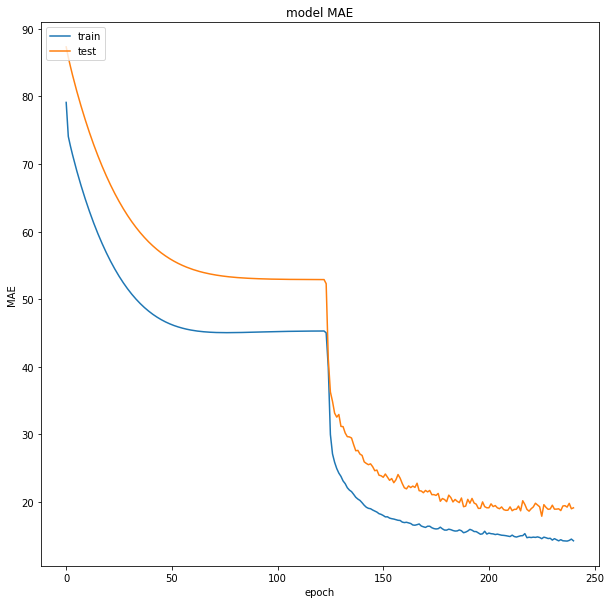

In [59]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_GRU_mae.png")




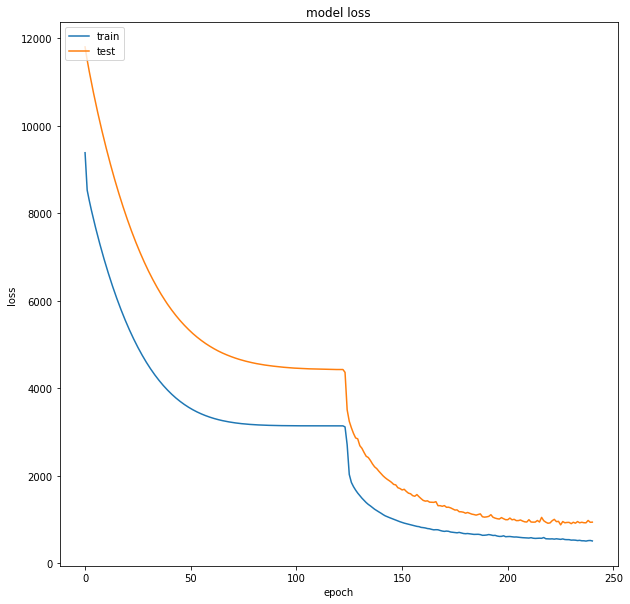

In [60]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_GRU_loss.png")

TESTING RESULTS

In [61]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [[test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]]
                       for id in test_df['id'].unique() if test_df[test_df['id']==id]['cycle'].max()>sequence_length]

seq_array_test_last = np.concatenate(seq_array_test_last).astype(np.float32)

smp=seq_array_test_last.shape[0]
n=seq_array_test_last.shape[2]
#seq_array_test_last = seq_array_test_last.reshape(smp, sequence_length, n, 1)


y_mask = [test_df[test_df['id']==id]['cycle'].max()>sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(smp,1).astype(np.float32)


In [62]:
label_array_test_last.shape

(92, 1)

In [63]:
seq_array_test_last.shape

(92, 50, 18)

92/92 [==============================] - 0s 320us/step

MAE: 12.737342793008555


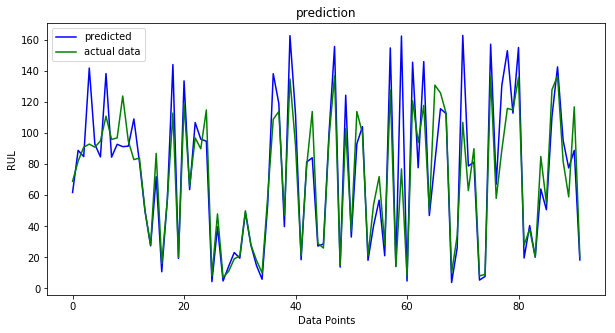

In [64]:
scores = model.evaluate(seq_array_test_last, label_array_test_last, verbose=1)
print('\nMAE: {}'.format(scores[1]))


y_pred_test = model.predict(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('RUL')
plt.xlabel('Data Points')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_GRU_verify.png")

In [65]:
# Using the scoring function

def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    for i in range(length):
        if (d[i] < 0):
            s += np.exp(-(d[i]/10))-1
        else:
            s += np.exp((d[i]/13))-1
    return s

def rmse(true, pred):
    d_squared = (pred - true)**2
    length = len(d_squared)
    err = 0
    for i in range(length):
        err += d_squared[i]
    err = np.sqrt(err/length)
    return err

In [66]:
sf = scoring_function(y_true_test,y_pred_test)
rmse_err = rmse(y_true_test,y_pred_test)

In [67]:
print(sf,rmse_err)

[1238.7003] [19.323824]


In [68]:
#Correlation between the predicted values and actual values
y=[i for sublist in y_true_test for i in sublist]
x=[i for sublist in y_pred_test for i in sublist]

In [69]:
np.corrcoef(y, x)

array([[1.        , 0.92187325],
       [0.92187325, 1.        ]])